## Build, Train & Score Model with PyTorch

<img src="assets/FolderStructure.jpg" width="500"/>




## Import Dependencies

In [1]:
# import fnmatch
# import os
# import pathlib
# import random
# import time

# import intel_extension_for_pytorch as ipex
# import matplotlib.pyplot as plt
# import numpy as np
# import psutil
# import seaborn as sns
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from torch.utils.data import DataLoader
# from torchvision import datasets, models, transforms
# from tqdm import tqdm

# sns.set_theme(style="whitegrid", palette="husl")


In [2]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
# Import the Intel Extension for PyTorch library, which provides optimizations for Intel architectures

import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
# Import the necessary libraries for data visualization and manipulation

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
# Import the required modules from PyTorch and torchvision for deep learning tasks and dataset handling

from tqdm import tqdm
# Import tqdm library for creating progress bars

sns.set_theme(style="whitegrid", palette="husl")
# Set the default seaborn theme and color palette for data visualization


2023-05-23 12:55:29,979 - numexpr.utils - INFO - Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-23 12:55:29,982 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


## Print Software Versions

In [3]:
print(f"torch version: {torch.__version__}")
print(f"ipex version: {ipex.__version__}")

torch version: 1.12.0+cpu
ipex version: 1.12.0+cpu


# AI Lifecycle is a helix!

<img src="assets/AI LifeCycle.PNG" width="500"/>

It is an iterative process. You go around the circle over time, improving the model, experimenting, refining the data, adding new data to shore-up weaknesses in coverage, rebalancing the data to prevent one class for dominating etc.

# Fine Tuning

<img src="assets/fine_tuning.PNG" width="500" />

           image src: https://d2l.ai/_images/finetune.svg


                                            
## Steps for fine tuning an image classification model
                                            
- Use a pretrained image classification model (Here we are using a variation of ResNet)
- Create a new neural network from this classification model, using the pretrained model as the backbone
- Relpace the last layer of the new neural network with a new output layer that matches the number of classes (3 here)
- Train the new model using the dataset (Dinosaur dataset), the output layer would be trained from init, and the backbone layers would be **fine-tuned** for the new dataset.

## Define Utility Functions

### seed_everything and set_env_vars

In [4]:
# def seed_everything(seed: int = 4242):
#     """set all random seeds using `seed`"""
#     print(f"seed set to: {seed}")
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)


# def set_env_vars() -> int:
#     """set openMP and torch params"""
#     num_physical_cores = psutil.cpu_count(logical=False)
#     print(f"setting omp num threads: {num_physical_cores}")
#     os.environ["OMP_NUM_THREADS"] =  str(num_physical_cores)
#     os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
#     os.environ["KMP_BLOCKTIME"] = "1"
#     return num_physical_cores


# seed_everything(9342)
# num_physical_cores = set_env_vars()


In [5]:
def seed_everything(seed: int = 4242):
    """Set all random seeds using the specified `seed`."""
    print(f"Seed set to: {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    # Set the random seeds for NumPy, Python's built-in random module, and PyTorch


def set_env_vars() -> int:
    """Set OpenMP and Torch environment variables."""
    num_physical_cores = psutil.cpu_count(logical=False)
    # Get the number of physical CPU cores

    print(f"Setting OMP num threads: {num_physical_cores}")
    os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    # Set the environment variables related to OpenMP to optimize CPU parallelism

    return num_physical_cores
    # Return the number of physical CPU cores

seed_everything(9342)
# Set the random seeds using a specific seed value (9342)

num_physical_cores = set_env_vars()
# Set the environment variables related to OpenMP and get the number of physical CPU cores


Seed set to: 9342
Setting OMP num threads: 12


## Define dataset transforms for training and validation sets

In [6]:
# # training, validation  dataset transforms
# imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
# img_transforms = {
#     "train": transforms.Compose(
#         [

#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.RandomRotation(45),
#             transforms.ToTensor(),
#             transforms.Normalize(*imagenet_stats),
#         ]
#     ),
#     "valid": transforms.Compose(
#         [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
#     ),
# }


In [7]:
# training, validation  dataset transforms
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
# Define the mean and standard deviation values for normalization in ImageNet dataset

img_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(45),
            # Apply random horizontal flip, random vertical flip, and random rotation of 45 degrees
            # These transformations are commonly used for data augmentation during training
            transforms.ToTensor(),
            # Convert the image to a tensor
            transforms.Normalize(*imagenet_stats),
            # Normalize the image using the specified mean and standard deviation values
        ]
    ),
    "valid": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    ),
}
# Create a dictionary of image transforms for different stages (train and valid)
# The transforms include converting the image to a tensor and normalizing it using the ImageNet statistics


## Create dataset for Training and Validation

In [8]:
ls data/output/train/

Fire/  NoFire/


In [9]:
# create dataset for Training and Validation
num_physical_cores = psutil.cpu_count(logical=False)
data_dir = pathlib.Path("./data/output/")
TRAIN_DIR = data_dir / "train"
VALID_DIR = data_dir / "val"

# no image transforms for validation data
#orig_train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["valid"])
train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["train"])
#train_data = torch.utils.data.ConcatDataset([orig_train_data, train_data])
valid_data = datasets.ImageFolder(VALID_DIR, transform=img_transforms["valid"])


## Define Utility Functions to visualize class distributions

### data_distribution and plot_data_distribution

In [10]:
# def data_distribution(dataset=train_data, path: str = TRAIN_DIR) -> dict:
#     """return dict of data distribtion of each class."""
#     cls_count = dict.fromkeys(dataset.class_to_idx, 0)
#     for cls in cls_count.keys():
#         cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
#     return cls_count


# def plot_data_distribution(data_dist: dict, title: str = ""):
#     """plot data distribution"""
#     cls, count = list(data_dist.keys()), list(data_dist.values())
#     p = sns.barplot(x=cls, y=count)
#     p.set_title(title)


In [11]:
def data_distribution(dataset=train_data, path: str = TRAIN_DIR) -> dict:
    """Return a dictionary of data distribution for each class."""
    cls_count = dict.fromkeys(dataset.class_to_idx, 0)
    # Create a dictionary with class labels as keys and initial count 0

    for cls in cls_count.keys():
        cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
        # Count the number of images with the ".png" extension in the corresponding class folder

    return cls_count
    # Return the dictionary containing the data distribution


def plot_data_distribution(data_dist: dict, title: str = ""):
    """Plot the data distribution using a bar plot."""
    cls, count = list(data_dist.keys()), list(data_dist.values())
    # Extract the class labels and their counts from the data distribution dictionary

    p = sns.barplot(x=cls, y=count)
    # Create a bar plot with class labels on the x-axis and counts on the y-axis

    p.set_title(title)
    # Set the title of the plot using the provided title argument


# Plot Data Distributions

train data dist: {'Fire': 87, 'NoFire': 90}


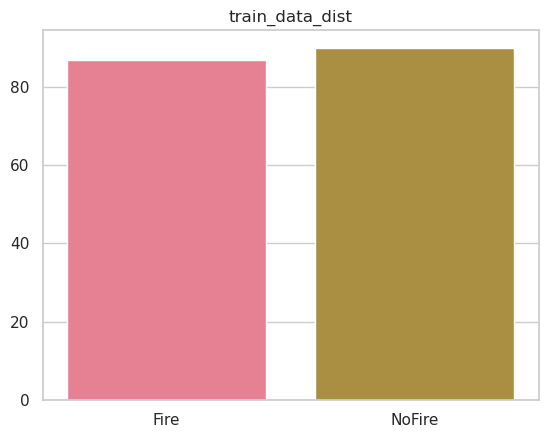

In [12]:
train_data_dist = data_distribution(train_data, path=TRAIN_DIR)
plot_data_distribution(train_data_dist, "train_data_dist")
print(f"train data dist: {train_data_dist}")


valid data dist: {'Fire': 9, 'NoFire': 10}


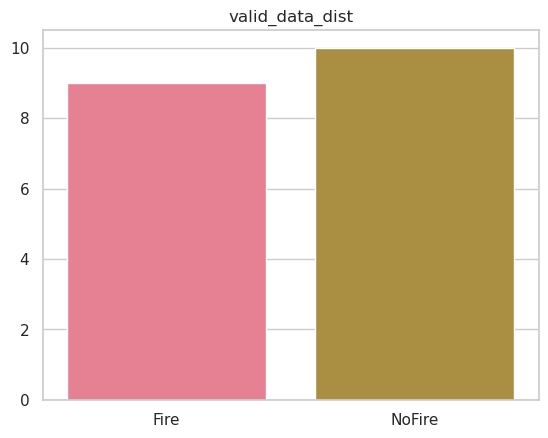

In [13]:
valid_data_dist = data_distribution(valid_data, path=VALID_DIR)
plot_data_distribution(valid_data_dist, "valid_data_dist")
print(f"valid data dist: {valid_data_dist}")


In [14]:
# create data loaders
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
print(f"batch size: {batch_size}")


batch size: 128


## Define Utility Functions to display data from dataloader



In [15]:
# def _denormalize(images, imagenet_stats):
#     """de normalize dataset using imagenet std and mean to show images"""
#     mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
#     std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
#     return images * std + mean


# def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=2, figsize=(10, 6)):
#     """show `num_data` of images and labels from dataloader."""
#     batch = next(iter(dataloader))  # batch of with images, batch of labels
#     imgs, labels = (
#         batch[0][:num_data],
#         batch[1][:num_data].tolist(),
#     )  # get num_data of images, labels
#     #plt.style.use("dark_background")
#     _, axes = plt.subplots(1, num_data, figsize=figsize)
#     for n in range(num_data):
#         axes[n].set_title(labels[n])
#         imgs[n] = _denormalize(imgs[n], imagenet_stats)
#         axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))


In [16]:
def _denormalize(images, imagenet_stats):
    """Denormalize the dataset using ImageNet standard deviation and mean to display images."""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean
    # Multiply the images by the standard deviation and add the mean to denormalize the dataset


def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=2, figsize=(10, 6)):
    """Show `num_data` images and labels from the dataloader."""
    batch = next(iter(dataloader))
    # Get the next batch from the dataloader
    # It contains a batch of images and a batch of labels

    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )
    # Get `num_data` images and labels from the batch

    _, axes = plt.subplots(1, num_data, figsize=figsize)
    # Create subplots for displaying the images

    for n in range(num_data):
        axes[n].set_title(labels[n])
        # Set the title of the subplot to the corresponding label

        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        # Denormalize the image using the provided imagenet_stats

        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))
        # Display the image in the subplot after applying the necessary transformations

## Display Sample Data

training data


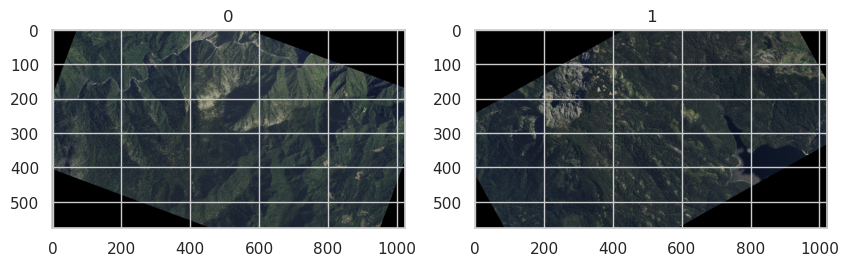

In [17]:
print("training data")
show_data(train_dataloader)


validation data


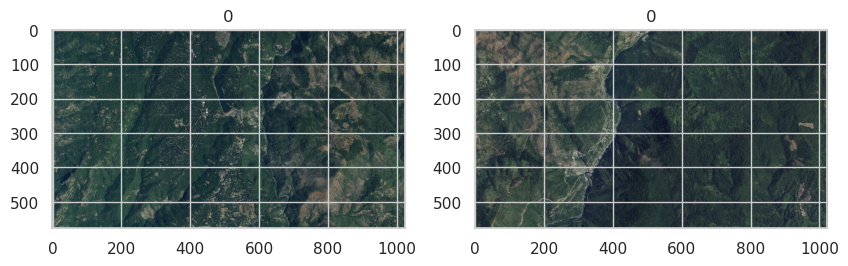

In [18]:
print("validation data")
show_data(valid_dataloader)


## Define the Model Class
    Our model is a Resnet18 based 3 class classification Deep Neural Network

### AKA FireFinder Class

In [19]:
class FireFinder(nn.Module):
    """
    A model to classify aerial images that to potentially predict forest fires.
    We are using a pretrained resnet backbone model
    and images given to model are classified into one of 3 classes.
    0 - no fire
    1 - fire likely

    We currently use the resnet18 model as a backbone
    """

    def __init__(self, backbone=18, simple=True, dropout= .4):
        super(FireFinder, self).__init__()
        backbones = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
        }
        #self.network = backbones[backbone](pretrained=True)
        self.network = backbones[backbone](weights=True)
        #self.network = backbones[backbone](weights='ResNet18_Weights.DEFAULT')
        for m, p in zip(self.network.modules(), self.network.parameters()):
            if isinstance(m, nn.BatchNorm2d):
                p.requires_grad = False
        if simple:
            self.network.fc = nn.Linear(self.network.fc.in_features, 2)
            nn.init.xavier_uniform_(self.network.fc.weight)
        else:
            fc = nn.Sequential(
                nn.Linear(self.network.fc.in_features, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(
                    256, 2
                ),  # here we are using 2 for `out_features` as the image given
                # to the model can be one of 3 classes (0 - no fire, 1 - fire likely)
            )
            for layer in fc.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
            self.network.fc = fc
            
            
    def forward(self, x_batch):
        return self.network(x_batch)


## Define Metrics - Utility class to measure accuracy of the model and plot metrics

In [20]:
class Metrics:
    """class that holds logic for calculating accuracy and printing it"""

    def __init__(self):
        self.acc = {"train": [], "val": []}
        self.loss = {"train": [], "val": []}

    @staticmethod
    @torch.no_grad()
    def accuracy(yhat, labels, debug):
        """accuracy of a batch"""
        yhat = torch.log_softmax(yhat, dim=1)  # softmax of logit output
        yhat = yhat.max(1)[1]# get index of max values
        if debug:
            print(f"outputs: {yhat} labels: {labels}")
            print(f" output == label ?: {torch.equal(yhat, labels)}")
        acc = yhat.eq(labels).sum() / len(yhat)
        return acc

    def __str__(self):
        return (
            f"loss:\n training set  : {self.loss['train'][-1]:.4}\n validation set: {self.loss['val'][-1]:.4}\n"
            f"accuracy:\n training set  : {self.acc['train'][-1]:.4}\n validation set: {self.acc['val'][-1]:.4} "
        )

    def plot(self):
        """plot loss and acc curves"""
        train_acc = [x * 100 for x in self.acc["train"]]
        val_acc = [x * 100 for x in self.acc["val"]]
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 2.5))
        ax[0].plot(self.loss["train"], "-o")
        ax[0].plot(self.loss["val"], "-o")
        ax[0].set_ylabel("loss")
        ax[0].set_title(f"Train vs validation loss")
        ax[1].plot(train_acc, "-o")
        ax[1].plot(val_acc, "-o")
        ax[1].set_ylabel("accuracy (%)")
        ax[1].set_title("Training vs validation acc")
        for x in ax:
            x.yaxis.grid(True)
            x.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            x.legend(["train", "validation"])
            x.set_xlabel("epoch")
        plt.show()


# Define Trainer Class

In [21]:
class Trainer:
    """Trainer class that takes care of training and validation passes."""

    def __init__(
        self,
        model,
        device="cpu",
        optimizer=torch.optim.SGD,
        epochs=10,
        lr=0.05,
        ipx=False,
    ):
        self.device = device
        self.model = model.to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.ipx = ipx
        self.epochs = epochs
        self.metrics = Metrics()
        self.lr = lr
        if isinstance(optimizer, torch.optim.Adam):
            self.lr = 2e-3
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

    def forward_pass(self, inputs, labels, debug=False):
        """Perform forward pass of models with `inputs`,
        calculate loss and accuracy and return it.
        """
        outputs = self.model(inputs)  # forward pass model
        loss = self.loss_fn(outputs, labels)  # calculate loss
        acc = self.metrics.accuracy(outputs, labels, debug=debug)
        return loss, acc

    def train_one_batch(self, train_dataloader, max_epoch=100):
        """Train the model using just one batch for max_epoch.
        use this function to debug the training loop"""
        self.model.train()
        self.train_dataloader = train_dataloader
        inputs, labels = next(iter(self.train_dataloader))
        for epoch in range(max_epoch):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels)
            loss.backward()  # calculate gradients
            self.optimizer.step()  # update params
            print(
                f"[Epoch: {epoch+1}]\
                    \n loss: {loss.item()/len(self.train_dataloader):.4f}\
                     \n acc: {acc.item()/len(self.train_dataloader):.4f}"
            )

    def train(self):
        """Training loop, return epoch loss and accuracy."""
        self.model.train()
        t_epoch_loss, t_epoch_acc = 0.0, 0.0
        start = time.time()
        for inputs, labels in tqdm(train_dataloader, desc="tr loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            if self.ipx:
                inputs = inputs.to(memory_format=torch.channels_last)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels)  # forward pass
            loss.backward()  # backward
            self.optimizer.step()  # update gradients
            t_epoch_loss += loss.item()
            t_epoch_acc += acc.item()
        print(time.time() - start)
        return (t_epoch_loss, t_epoch_acc)

    @torch.no_grad()
    def validate(self):
        """Validation loop, return validation epoch loss and accuracy."""
        self.model.eval()
        v_epoch_loss, v_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(self.valid_dataloader, desc="ev loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            loss, acc = self.forward_pass(inputs, labels)
            v_epoch_loss += loss.item()
            v_epoch_acc += acc.item()
        return (v_epoch_loss, v_epoch_acc)

    def _to_ipx(self):
        """convert model memory format to channels_last to IPEX format."""
        self.model.train()
        self.model = self.model.to(memory_format=torch.channels_last)
        self.model, self.optimizer = ipex.optimize(
            self.model, optimizer=self.optimizer, dtype=torch.float32
        )

    def fine_tune(self, train_dataloader, valid_dataloader, debug=False):
        """Fine tune `self.model` using training set and measure perf using
        training and validation set.
        `debug`: if True, will run train_one_batch function with one batch
        of train_dataloader to see if we can overfit the model, used to debug
        the training loop.

        `train_dataloader`: training set
        `valid_dataloader`: validation set
        """
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        if debug:
            self.train_one_batch()
        else:
            time_per_epoch = []
            if self.ipx:
                self._to_ipx()
            print(f"fine tuning model for max epochs: {self.epochs} : lr = {self.lr}")
            for epoch in range(self.epochs):
                print(f"Epoch: [{epoch+1}]")
                st_time = time.perf_counter()
                t_epoch_loss, t_epoch_acc = self.train()
                fn_time = time.perf_counter()
                time_per_epoch.append(fn_time - st_time)
                v_epoch_loss, v_epoch_acc = self.validate()
                self.metrics.loss["train"].append(t_epoch_loss / len(train_dataloader))
                self.metrics.loss["val"].append(v_epoch_loss / len(valid_dataloader))
                self.metrics.acc["train"].append(t_epoch_acc / len(train_dataloader))
                self.metrics.acc["val"].append(v_epoch_acc / len(valid_dataloader))
                print(self.metrics)
            return time_per_epoch


## Train model

In [22]:
simple = False
epochs = 20
ipx = True 
dropout = .33
lr = .02

model_name = f"ON_resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
print(model_name)
# set num threads == number of physical cores
torch.set_num_threads(num_physical_cores)
print(f"torch num_threads: {torch.get_num_threads()}")
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"

start = time.time()
model = FireFinder(simple=simple, dropout= dropout)  # init model, use simple = True for use w OpenVINO module 9
trainer = Trainer(model, lr = lr, epochs=epochs, ipx=ipx) # set up trainer with the model, use ipx = False to be compatible w OpenVINO
tft = trainer.fine_tune(train_dataloader, valid_dataloader)

print(f"time elapsed: {time.time() - start}")

ON_resnet18_simpleFalse_IPEXTrue_Epochs20_dropout0.33_batch128
torch num_threads: 12


/home/u177248/.conda/envs/openvinopytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fine tuning model for max epochs: 20 : lr = 0.02
Epoch: [1]


tr loop: 100%|██████████| 2/2 [00:48<00:00, 24.47s/it]


48.97211480140686


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


loss:
 training set  : 1.062
 validation set: 1.032
accuracy:
 training set  : 0.5812
 validation set: 0.4737 
Epoch: [2]


tr loop: 100%|██████████| 2/2 [00:48<00:00, 24.09s/it]


48.18017387390137


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 1.936
 validation set: 0.8777
accuracy:
 training set  : 0.499
 validation set: 0.5263 
Epoch: [3]


tr loop: 100%|██████████| 2/2 [00:50<00:00, 25.22s/it]


50.45184254646301


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


loss:
 training set  : 1.374
 validation set: 0.8329
accuracy:
 training set  : 0.5577
 validation set: 0.5789 
Epoch: [4]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.95s/it]


47.89238476753235


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


loss:
 training set  : 1.159
 validation set: 0.7309
accuracy:
 training set  : 0.5498
 validation set: 0.6842 
Epoch: [5]


tr loop: 100%|██████████| 2/2 [00:48<00:00, 24.43s/it]


48.85665512084961


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.7676
 validation set: 0.6498
accuracy:
 training set  : 0.6497
 validation set: 0.5789 
Epoch: [6]


tr loop: 100%|██████████| 2/2 [00:56<00:00, 28.22s/it]


56.461742877960205


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.6302
 validation set: 0.7031
accuracy:
 training set  : 0.7044
 validation set: 0.5789 
Epoch: [7]


tr loop: 100%|██████████| 2/2 [00:54<00:00, 27.49s/it]


54.98774194717407


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.5255
 validation set: 0.8736
accuracy:
 training set  : 0.7417
 validation set: 0.5263 
Epoch: [8]


tr loop: 100%|██████████| 2/2 [00:48<00:00, 24.04s/it]


48.086405754089355


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


loss:
 training set  : 0.387
 validation set: 0.5613
accuracy:
 training set  : 0.8181
 validation set: 0.6842 
Epoch: [9]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.90s/it]


47.81367349624634


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.4205
 validation set: 0.5835
accuracy:
 training set  : 0.8395
 validation set: 0.6842 
Epoch: [10]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.80s/it]


47.59247279167175


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.3824
 validation set: 0.5816
accuracy:
 training set  : 0.8591
 validation set: 0.6842 
Epoch: [11]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.85s/it]


47.72426390647888


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.4731
 validation set: 0.4291
accuracy:
 training set  : 0.7652
 validation set: 0.7368 
Epoch: [12]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.89s/it]


47.77915596961975


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.4048
 validation set: 0.4352
accuracy:
 training set  : 0.8199
 validation set: 0.7895 
Epoch: [13]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.87s/it]


47.73864412307739


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.3623
 validation set: 0.6788
accuracy:
 training set  : 0.8356
 validation set: 0.6316 
Epoch: [14]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.81s/it]


47.629692792892456


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.3349
 validation set: 0.4747
accuracy:
 training set  : 0.8317
 validation set: 0.6316 
Epoch: [15]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.89s/it]


47.788262128829956


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


loss:
 training set  : 0.3287
 validation set: 0.7011
accuracy:
 training set  : 0.8316
 validation set: 0.6316 
Epoch: [16]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.92s/it]


47.84996175765991


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


loss:
 training set  : 0.2975
 validation set: 0.4223
accuracy:
 training set  : 0.863
 validation set: 0.7368 
Epoch: [17]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.92s/it]


47.8455708026886


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


loss:
 training set  : 0.2706
 validation set: 0.5637
accuracy:
 training set  : 0.8866
 validation set: 0.7368 
Epoch: [18]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.84s/it]


47.69381237030029


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.2396
 validation set: 0.5472
accuracy:
 training set  : 0.8983
 validation set: 0.7368 
Epoch: [19]


tr loop: 100%|██████████| 2/2 [00:48<00:00, 24.05s/it]


48.10982584953308


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


loss:
 training set  : 0.2707
 validation set: 0.429
accuracy:
 training set  : 0.8786
 validation set: 0.7368 
Epoch: [20]


tr loop: 100%|██████████| 2/2 [00:47<00:00, 23.85s/it]


47.709707498550415


ev loop: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

loss:
 training set  : 0.3145
 validation set: 0.3589
accuracy:
 training set  : 0.8532
 validation set: 0.8947 
time elapsed: 1014.9896049499512


## Training / Validation loss and accuracy metrics

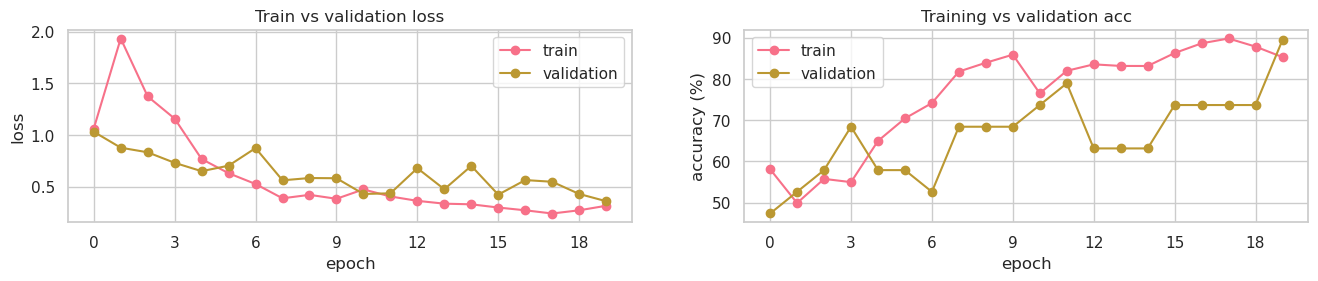

In [23]:
trainer.metrics.plot()

## Save the model 

Save it for later use

In [24]:
# JIT method
model = trainer.model
model.eval()
with torch.no_grad():
    model_scripted = torch.jit.script(model)  # Export to TorchScript
    model_scripted.save(f"models/{model_name}.pt")  # Save

# STATE_DICT method
torch.save(model.network.state_dict(), f'{model_name}_StateDict.pt')
print(model_name)
print(f'{model_name}_StateDict')

ON_resnet18_simpleFalse_IPEXTrue_Epochs20_dropout0.33_batch128
ON_resnet18_simpleFalse_IPEXTrue_Epochs20_dropout0.33_batch128_StateDict


In [25]:
model_name

'ON_resnet18_simpleFalse_IPEXTrue_Epochs20_dropout0.33_batch128'

## Load a Saved Model

Use this to load a previously created model to test if we were successfully able to save the model.

for example:
```python
model_name = 'ON_resnet18_simpleFalse_IPEXTrue_Epochs6_dropout0.5_batch128'
```

In [26]:
# JIT method
model_name = "resnet18_simple_NOIPEX_6Epochs"
model_name = "ON_resnet18_simpleFalse_IPEXTrue_Epochs40_dropout0.33_batch128"

model_read = torch.jit.load(f"models/{model_name}.pt")
# Load the pre-trained model from the specified file path
# The `model_name` is used to construct the file path, assuming it has the ".pt" extension

model_read.eval()
# Set the loaded model to evaluation mode
# This disables certain operations like dropout and batch normalization during inference

# STATE_DICT method
# model = models.resnet18()
# PATH = 'models/bc_resnet18_simple_NOIPEX_30Epochs_StateDict_gold.pt'
# model.fc = nn.Linear(model.fc.in_features, 3)
# model.load_state_dict(torch.load(PATH))
# model.eval()

# model_read = models.resnet18()

RecursiveScriptModule(
  original_name=FireFinder
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchN

## Infer Function

Used to score and get associated filename for each scored image

In [27]:
# class ImageFolderWithPaths(datasets.ImageFolder):
#     """custom ImageFolder to get the filepaths along with the image and label data."""

#     def __getitem__(self, index):
#         paths = ((self.imgs[index][0]),)
#         return super().__getitem__(index) + paths


# def infer(model, data_path: str):
#     """give trained `model` & `data_path` where images whose
#     labels have to be predicted are kept.

#     `data_path`: path to data eg. ./test/<random_class>/*.png
#     it's important to have a folder with a`random class` name as ImgFolder
#     expects it.

#     returns: (
#         images: images loaded from disk for inferece,
#         yhats: predicted labels
#         paths: image file-path on disk        )
#     """
#     transform = transforms.Compose(
#         [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
#     )
#     data = ImageFolderWithPaths(data_path, transform=transform)
#     dataloader = DataLoader(
#         data,
#         batch_size=4,
#     )
#     yhats = []
#     images = []
#     paths = []
#     for (imgs, _, fpaths) in dataloader:
#         yhat = model(imgs)
#         yhat = yhat.max(1)[1]
#         yhat = yhat.data.cpu().numpy()
#         yhats.extend(yhat)
#         paths.extend(fpaths)
#         images.extend(imgs.data.cpu())
#     return images, yhats, paths


In [28]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)  # Extract the filepath from the dataset
        return super().__getitem__(index) + paths  # Return the image, label, and filepath


def infer(model, data_path: str):
    """Given a trained `model` and a `data_path` where images whose
    labels have to be predicted are kept.

    Args:
        model (torch.nn.Module): Trained model for inference.
        data_path (str): Path to the data, e.g., "./test/<random_class>/*.png".
                         It's important to have a folder with a `random_class` name
                         as ImageFolder expects it.

    Returns:
        Tuple:
        - images (List[Tensor]): Images loaded from disk for inference.
        - yhats (List[int]): Predicted labels.
        - paths (List[str]): Image file-paths on disk.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )  # Define the transformations to apply to the images
    data = ImageFolderWithPaths(data_path, transform=transform)  # Create a custom ImageFolder instance
    dataloader = DataLoader(
        data,
        batch_size=4,
    )  # Create a data loader to load the images in batches
    yhats = []  # List to store the predicted labels
    images = []  # List to store the loaded images
    paths = []  # List to store the file-paths of the images
    for (imgs, _, fpaths) in dataloader:  # Iterate over the batches of images
        yhat = model(imgs)  # Perform inference on the model
        yhat = yhat.max(1)[1]  # Get the index of the predicted label with the highest probability
        yhat = yhat.data.cpu().numpy()  # Convert the predicted labels to a numpy array
        yhats.extend(yhat)  # Add the predicted labels to the yhats list
        paths.extend(fpaths)  # Add the file-paths to the paths list
        images.extend(imgs.data.cpu())  # Add the loaded images to the images list
    return images, yhats, paths  # Return the loaded images, predicted labels, and file-paths

## How to use the Infer()

In [29]:
!mkdir data/test
!mkdir  data/test/unknown
!cp data/output/val/Fire/*.png data/test/unknown/
!cp data/output/val/NoFire/*.png data/test/unknown/

mkdir: cannot create directory ‘data/test’: File exists
mkdir: cannot create directory ‘data/test/unknown’: File exists


In [30]:
# imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
# images, yhats, img_paths = infer(
#     model, data_path="./data//test/"
# )
# infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=10, shuffle=True)
# print("infered images with labels")
# show_data(infer_dataloader, imagenet_stats, 10, figsize=(20, 8))


inferred images with labels


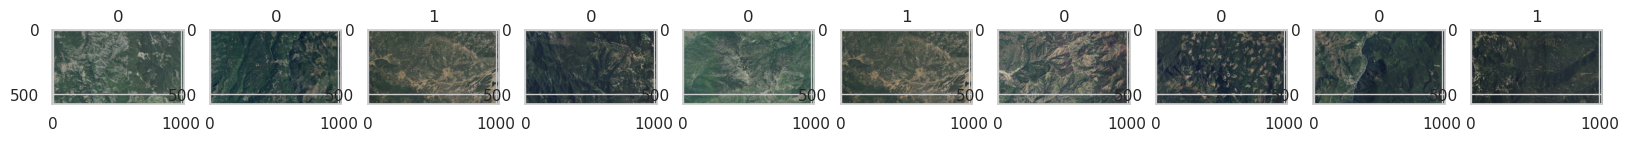

In [31]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
# Define the mean and standard deviation values for normalization in ImageNet dataset

images, yhats, img_paths = infer(
    model, data_path="./data//test/"
)
# Call the `infer` function to predict labels for images in the specified data path
# The resulting images, predicted labels, and image file paths are assigned to variables

infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=10, shuffle=True)
# Create a data loader with the inferred images and their corresponding labels
# The data is zipped together and loaded in batches of size 10 with shuffling

print("inferred images with labels")
# Display a message indicating that the following images have been inferred

show_data(infer_dataloader, imagenet_stats, 10, figsize=(20, 8))
# Call the `show_data` function to visualize the inferred images with their labels
# The `infer_dataloader` provides the data, `imagenet_stats` is used for normalization,
# and the display settings are configured with `figsize=(20, 8)`

If you have any issues or want to contribute, please contact our authors:
Intel oneAPI Solution Architect
- Unnikrishnan Nair, Rahul [rahul.unnikrishnan.nair (at) intel.com]
- Chesebrough, Bob [bob.chesebrough (at) intel.com]

## Lab

1. What will happen to the accuracy curves & training time:
    - if we use ResNet50 as the backbone instead of ResNet18?
    - if another optimizer is used, for Eg. Instead of SGD, if we used Adam?
2. Difference in time taken for training with ipex and without ipex?</br>
    **Note**: To do this experiment, call the `fine_tune` method using `ipx=False`
3. If we don't use the fine-tuning approach and use the same Resnet18 with pretraining turned off (`pretrain=False`), how many epochs do we have to train the model?
4. If we don't `zero` the gradients in the training loop, what effect does it have on training?
5. Can a custom CNN-based classifier be trained to classify our dataset more accurately than the approach we used here?



## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 